In [1]:
%run setup.py

In [2]:
stars = pd.read_excel(rootpath+'surface/sample/samples.xlsx')
idx = (stars['ifmodelling']==1) & ((stars['e_lum_J']/stars['lum_J'])<0.3) & np.isfinite(stars['Teff']) & np.isfinite(stars['[M/H]'])

stars = stars.loc[idx,:].reset_index(drop=True)
       
idx = ~np.isfinite(stars['Dnu'])
stars.loc[idx, 'Dnu'] = stars.loc[idx, 'Dnu_guess']

# modes = pd.read_excel(rootpath+'surface/sample/modes.xlsx')

In [6]:
suf = '_micp'
original_cols = ['Dnu_freq_o', 'Dnu_freq', 'star_mass', 'radius', 'amlt']
to_append_cols = ['Dnu_freq_o'+suf, 'Dnu_freq'+suf, 'mass'+suf, 'radius'+suf, 'amlt'+suf]
to_append_e_cols = ['e_'+col for col in to_append_cols]

def multi(inputs):
    istar, star = inputs
    filepath = rootpath+'surface/exp/results_spec_gaia_nu_sc/{:0.0f}/summary_prob.txt'.format(star['KIC'])
    if not os.path.exists(filepath): return [np.nan]*(len(to_append_cols)*2)
    data = ascii.read(filepath, delimiter=',')
    var = list(data[original_cols][1])
    e_var = list((np.array(list(data[original_cols][2])) - np.array(list(data[original_cols][0])))/2.)
    return var + e_var

r = process_map(multi, stars.iterrows(), total=len(stars), max_workers=12)
stars.loc[:, to_append_cols+to_append_e_cols]  = np.array(r)


suf = '_mic'
original_cols = ['Dnu_freq', 'Dnu_freq_sc', 'star_mass', 'radius', 'amlt']
to_append_cols = ['Dnu_freq_o'+suf, 'Dnu_freq'+suf, 'mass'+suf, 'radius'+suf, 'amlt'+suf]
to_append_e_cols = ['e_'+col for col in to_append_cols]

def multi(inputs):
    istar, star = inputs
    filepath = rootpath+'surface/exp/results_spec_gaia_nu/{:0.0f}/summary_prob.txt'.format(star['KIC'])
    if not os.path.exists(filepath): return [np.nan]*(len(to_append_cols)*2)
    data = ascii.read(filepath, delimiter=',')
    var = list(data[original_cols][1])
    e_var = list((np.array(list(data[original_cols][2])) - np.array(list(data[original_cols][0])))/2.)
    return var + e_var

r = process_map(multi, stars.iterrows(), total=len(stars), max_workers=12)
stars.loc[:, to_append_cols+to_append_e_cols]  = np.array(r)

  0%|          | 0/1276 [00:00<?, ?it/s]

  0%|          | 0/1276 [00:00<?, ?it/s]

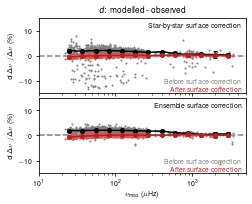

In [9]:
import matplotlib.colors
norm = matplotlib.colors.Normalize(vmin=-0.5,vmax=0.5)


fig, axes = plt.subplots(figsize=mnras_size(ratio=0.8,column='one'), nrows=2, ncols=1, 
                         squeeze=False, constrained_layout=True)
axes = axes.reshape(-1)

# idx = ((stars['numax']>0) & (stars['ALPHA_M']<0.05) & (stars['ALPHA_M']>-0.05)) |(stars['names']=='Sun') # & np.isfinite(stars['DPi1_V16'])
# sample = stars.loc[idx,:]
idx = np.isfinite(stars['Dnu_freq_mic']) & ((stars['Dnu_freq_micp']/stars['Dnu']-1)<0.05) & (stars['Dnu']>3.0)

sample = stars.loc[idx,:]

styles1 = {'marker':'.', 'c':'gray', 's':4,}
estyles1 = {'linestyle':'-', 'color':'k', 'ecolor':'k', 'capsize':2, 'marker':'o', 'ms':4, 'zorder':10}


styles2 = {'marker':'.', 'c':red, 's':4, 'zorder':10}
estyles2 = {'linestyle':'-', 'color':'firebrick', 'ecolor':'firebrick', 'capsize':2, 'marker':'o', 'ms':4, 'zorder':10}


var = ['mic', 'micp']
# ['density', 'g', 'Dnu_scaling', 'Dnu_freq', 'Teff', 'amlt', 'Yinit', 'luminosity', 'numax']
lvar = ['Dnu', 'Dnu', 't']

for iax, ax in enumerate(axes[0:2]):
    
    var1 = 'Dnu_freq_o_'+var[iax]
    evar1 = 'e_Dnu_freq_o_'+var[iax]
    
    var2 = 'Dnu_freq_'+var[iax]
    evar2 = 'e_Dnu_freq_'+var[iax]
    
    var0 = 'Dnu'
    evar0 = 'e_Dnu'

    x = sample.loc[:,'numax']
    y1 = (sample.loc[:,var1]/sample.loc[:,var0]-1)*100
    y2 = (sample.loc[:,var2]/sample.loc[:,var0]-1)*100
    
    ex = sample.loc[:,'e_numax']
    ey1 = y1*((sample.loc[:,evar1]/sample.loc[:,var1])**2.0 + (sample.loc[:,evar0]/sample.loc[:,var0])**2.0)**0.5
    ey2 = y2*((sample.loc[:,evar2]/sample.loc[:,var2])**2.0 + (sample.loc[:,evar0]/sample.loc[:,var0])**2.0)**0.5
    
    idx = np.isfinite(x) & np.isfinite(y1) & np.isfinite(ey1) & np.isfinite(ex) & np.isfinite(y2) & np.isfinite(ey2)
    x,ex,y1,ey1,y2,ey2 = x[idx],ex[idx],y1[idx],ey1[idx],y2[idx],ey2[idx]
    
    xcs, medians, stds = se.get_binned_median(x, y1, np.logspace(np.log(20), np.log(3500), 14, base=np.e))
    ax.scatter(x, y1, rasterized=True,  **styles1)
#     ax.errorbar(x, y1, xerr=ex, yerr=ey1, **errorstyles1)
    ax.errorbar(xcs, medians, yerr=stds, **estyles1)
    
    xcs, medians, stds = se.get_binned_median(x, y2, np.logspace(np.log(20), np.log(3500), 14, base=np.e))
    ax.scatter(x, y2, rasterized=True,  **styles2)
#     ax.errorbar(x, y2, xerr=ex, yerr=ey2, **errorstyles2)
    ax.errorbar(xcs, medians, yerr=stds, **estyles2)
    
    ax.set_xlim(10, 5000)
    

    ax.set_xscale('log')
    ax.axhline(0., linestyle='--', color='gray')
    ax.set_ylabel('$d \\ \\Delta\\nu \\ / \\Delta\\nu$ (\\%)')


axes[0].set_title('$d$: modelled - observed')
axes[0].text(0.98, 0.95, 'Star-by-star surface correction', transform=axes[0].transAxes, ha='right', va='top', color='k')
axes[0].text(0.98, 0.20, 'Before surface correction', transform=axes[0].transAxes, ha='right', va='top', color='gray')
axes[0].text(0.98, 0.10, 'After surface correction', transform=axes[0].transAxes, ha='right', va='top', color='firebrick')

axes[1].text(0.98, 0.95, 'Ensemble surface correction', transform=axes[1].transAxes, ha='right', va='top', color='k')
axes[1].text(0.98, 0.20, 'Before surface correction', transform=axes[1].transAxes, ha='right', va='top', color='gray')
axes[1].text(0.98, 0.10, 'After surface correction', transform=axes[1].transAxes, ha='right', va='top', color='firebrick')


axes[-1].set_xlabel('$\\nu_{\\rm max}$ ($\\mu$Hz)')
axes[0].set_xticklabels([])
axes[0].set_ylim(-15,15)
axes[1].set_ylim(-15,15)
# axes[0].set_ylim(-3,3)
# axes[1].set_ylim(-3,3)
fig.set_constrained_layout_pads(w_pad=0.01, h_pad=0.01, hspace=0, wspace=0)



filename = 'Fig.5_Dnu_diff.pdf'

# plt.savefig(filename)
# os.system(to_overleaf(filename, 'figures'))